In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Load data
print("Loading data...")
df = pd.read_csv('../data/raw_data/train.csv')

Loading data...


In [36]:
df

,obs,job_title,job_posted_date,salary_category,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,1,Others,2024/07,High,NY,A,0.6429,False,False,True,...,-0.362079,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340
1,2,Job_Title_1,2024/07,Low,CA,A,0.4678,False,False,False,...,-0.300989,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364
2,3,Others,2024/07,Low,CA,A,0.4610,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,Others,2024/07,Low,CA,A,0.5064,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,Others,2024/07,Low,CA,A,0.4640,False,False,False,...,-0.406159,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.276270,-0.696853,-0.601466,0.089939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,1276,Job_Title_21,2024/06,High,CA,A,0.5391,False,False,False,...,-0.089303,-0.471856,0.002497,0.245694,0.251105,0.119141,-0.184764,-0.482634,-0.819574,-0.241306
1276,1277,Others,2024/07,High,CA,A,0.7151,True,False,False,...,-0.079315,-0.796785,0.154025,-0.462344,-0.053803,-0.297083,-0.277624,-0.924568,-0.897608,-0.236864
1277,1278,Job_Title_10,2024/08,Medium,NY,A,0.5791,False,False,False,...,-0.030367,-0.329539,-0.429462,-0.141221,0.119336,-0.483549,-0.146601,-0.715821,-0.739832,-0.128655
1278,1279,Job_Title_2,2024/07,Medium,CA,A,0.7082,False,False,False,...,-0.213866,-0.242665,-0.311564,-0.032751,-0.301447,-0.480434,-0.112401,-0.828844,-1.066424,-0.228583


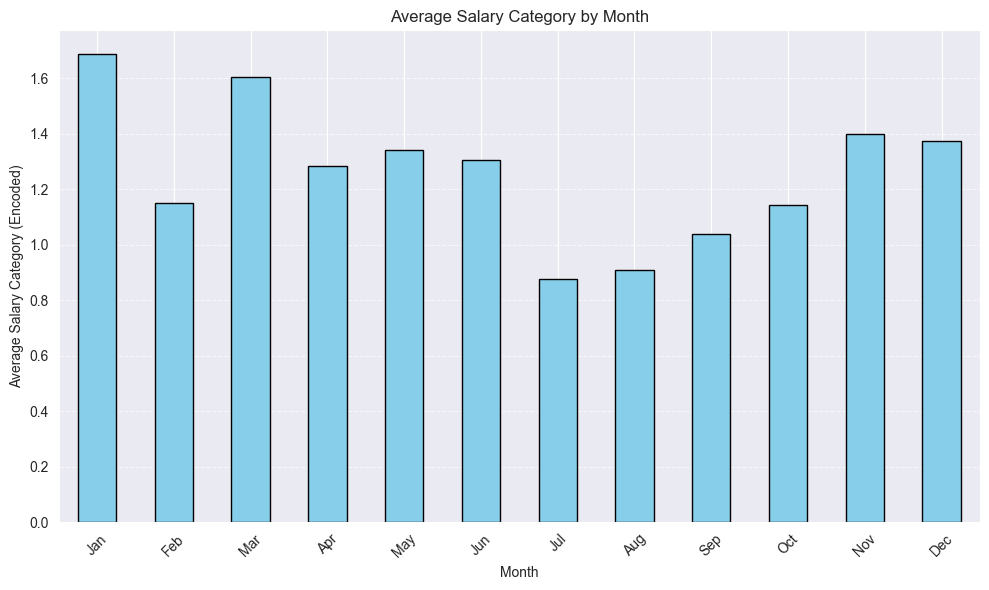

In [42]:
mapping = {"Low": 0, "Medium": 1, "High": 2}
df["salary_category"] = df["salary_category"].map(mapping)

# Assume df has columns: "job_posted_date" and "target"
df["job_posted_date"] = pd.to_datetime(df["job_posted_date"], errors="coerce")

# Step 1: Extract month
df["month"] = df["job_posted_date"].dt.month

# Step 2: Target encode the month
# Compute average target per month
month_target_mean = df.groupby("month")["salary_category"].mean()

# Map it back to the dataframe
df["month_encoded"] = df["month"].map(month_target_mean)

plt.figure(figsize=(10, 6))
month_target_mean.sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Salary Category by Month")
plt.xlabel("Month")
plt.ylabel("Average Salary Category (Encoded)")
plt.xticks(ticks=range(12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Monthly Salary Category Stats:
           mean       std  count
month                           
1.0    1.688889  0.556867     45
2.0    1.152174  0.729304     46
3.0    1.604167  0.609834     48
4.0    1.285714  0.677003     49
5.0    1.342857  0.739873     70
6.0    1.307692  0.767193    156
7.0    0.877250  0.864409    611
8.0    0.909639  0.879547    166
9.0    1.040000  0.734847     25
10.0   1.142857  0.792825     21
11.0   1.400000  0.516398     10
12.0   1.375000  0.751343     32


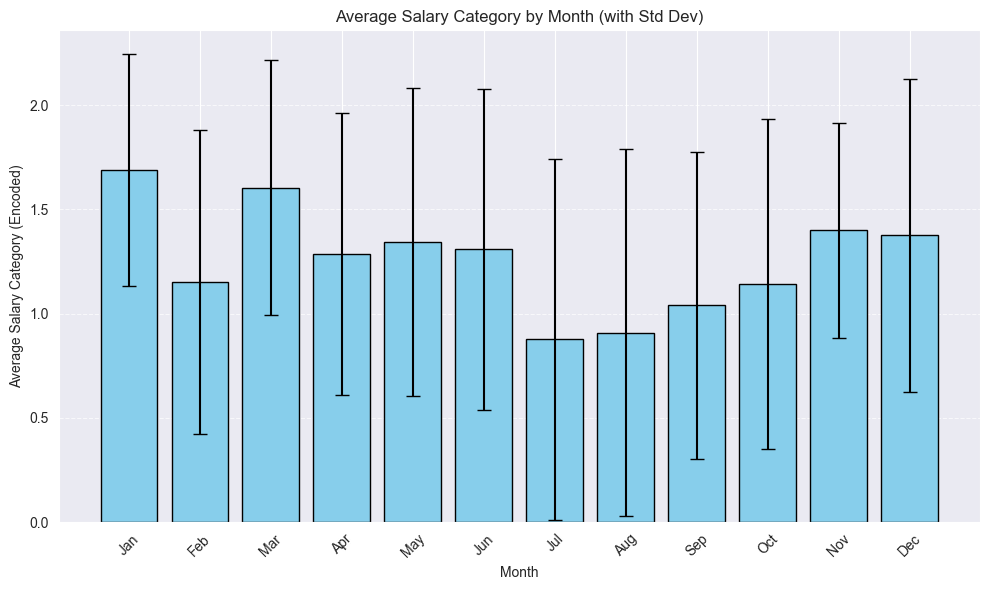

In [44]:
# Group by month and compute mean, std, and count
monthly_stats = df.groupby("month")["salary_category"].agg(['mean', 'std', 'count'])

# Print the stats
print("Monthly Salary Category Stats:")
print(monthly_stats)

# Plot with error bars (std)
plt.figure(figsize=(10, 6))
plt.bar(
    monthly_stats.index,
    monthly_stats["mean"],
    yerr=monthly_stats["std"],
    capsize=5,
    color="skyblue",
    edgecolor="black"
)
plt.title("Average Salary Category by Month (with Std Dev)")
plt.xlabel("Month")
plt.ylabel("Average Salary Category (Encoded)")
plt.xticks(ticks=range(1, 13), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [6]:
# Extract job description columns
job_desc_cols = [f"job_desc_{i:03d}" for i in range(1, 301)]
df_desc = df[job_desc_cols].copy()

In [7]:
# Get the actual salary categories for comparison
salary_mapping = {"Low": 0, "Medium": 1, "High": 2}
true_labels = df["salary_category"].map(salary_mapping).values

print(f"Shape of job description data: {df_desc.shape}")
print(f"Number of missing values: {df_desc.isnull().sum().sum()}")

Shape of job description data: (1280, 300)
Number of missing values: 0


In [8]:
# Data preprocessing
print("\nPreprocessing data...")

# Replace zeros with NaN (as mentioned in original code)
df_desc = df_desc.replace(0, np.nan)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
df_desc_imputed = imputer.fit_transform(df_desc)

# Scale the data
scaler = StandardScaler()
df_desc_scaled = scaler.fit_transform(df_desc_imputed)

print(f"Shape after preprocessing: {df_desc_scaled.shape}")


Preprocessing data...
Shape after preprocessing: (1280, 300)


In [9]:
# 1. Dimensionality Reduction for Visualization
print("\nPerforming PCA for visualization...")
pca = PCA(n_components=2, random_state=42)
pca_features = pca.fit_transform(df_desc_scaled)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained by 2 components: {sum(pca.explained_variance_ratio_):.2%}")

# Check how many components needed for 90% variance
pca_full = PCA(random_state=42)
pca_full.fit(df_desc_scaled)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum >= 0.9) + 1
print(f"Components needed for 90% variance: {n_components_90}")


Performing PCA for visualization...
PCA explained variance ratio: [0.09961302 0.06817461]
Total variance explained by 2 components: 16.78%
Components needed for 90% variance: 105


In [10]:
# 2. Elbow Method for Optimal K
print("\nFinding optimal number of clusters using elbow method...")
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_desc_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_desc_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")


Finding optimal number of clusters using elbow method...
K=2: Inertia=361544.39, Silhouette=0.129
K=3: Inertia=348549.31, Silhouette=0.056
K=4: Inertia=338249.45, Silhouette=0.076
K=5: Inertia=327575.02, Silhouette=0.058
K=6: Inertia=321832.64, Silhouette=0.058
K=7: Inertia=317126.17, Silhouette=0.033
K=8: Inertia=312272.43, Silhouette=0.025
K=9: Inertia=310012.28, Silhouette=0.032
K=10: Inertia=309166.13, Silhouette=0.046


In [11]:
# 3. Apply different clustering algorithms
print("\nApplying clustering algorithms...")

# K-means with different K values
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_3_labels = kmeans_3.fit_predict(df_desc_scaled)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_5_labels = kmeans_5.fit_predict(df_desc_scaled)

# Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(df_desc_scaled)

# DBSCAN
dbscan = DBSCAN(eps=5.0, min_samples=10)
dbscan_labels = dbscan.fit_predict(df_desc_scaled)
n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)


Applying clustering algorithms...


In [12]:
# 4. Evaluate clustering quality
print("\nClustering evaluation metrics:")
print("-" * 50)

def evaluate_clustering(X, labels, method_name):
    if len(set(labels)) > 1:  # Need at least 2 clusters
        sil_score = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        db_score = davies_bouldin_score(X, labels)
        print(f"{method_name}:")
        print(f"  Silhouette Score: {sil_score:.3f}")
        print(f"  Calinski-Harabasz Score: {ch_score:.2f}")
        print(f"  Davies-Bouldin Score: {db_score:.3f} (lower is better)")
        return sil_score, ch_score, db_score
    else:
        print(f"{method_name}: Only one cluster found")
        return None, None, None

metrics = {}
metrics['kmeans_3'] = evaluate_clustering(df_desc_scaled, kmeans_3_labels, "K-means (K=3)")
metrics['kmeans_5'] = evaluate_clustering(df_desc_scaled, kmeans_5_labels, "K-means (K=5)")
metrics['hierarchical'] = evaluate_clustering(df_desc_scaled, hierarchical_labels, "Hierarchical (K=3)")
if n_dbscan_clusters > 1:
    metrics['dbscan'] = evaluate_clustering(df_desc_scaled, dbscan_labels, f"DBSCAN ({n_dbscan_clusters} clusters)")


Clustering evaluation metrics:
--------------------------------------------------
K-means (K=3):
  Silhouette Score: 0.056
  Calinski-Harabasz Score: 64.94
  Davies-Bouldin Score: 3.673 (lower is better)
K-means (K=5):
  Silhouette Score: 0.058
  Calinski-Harabasz Score: 54.90
  Davies-Bouldin Score: 3.124 (lower is better)
Hierarchical (K=3):
  Silhouette Score: 0.027
  Calinski-Harabasz Score: 46.31
  Davies-Bouldin Score: 3.895 (lower is better)


In [13]:
# 5. Compare with actual salary categories
print("\n" + "-" * 50)
print("Comparison with actual salary categories:")

# Use PCA features for clustering comparison
pca_50 = PCA(n_components=50, random_state=42)
pca_50_features = pca_50.fit_transform(df_desc_scaled)

# K-means on reduced features
kmeans_pca = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_pca_labels = kmeans_pca.fit_predict(pca_50_features)

print(f"Clustering on PCA features (50 components):")
evaluate_clustering(pca_50_features, kmeans_pca_labels, "K-means on PCA")


--------------------------------------------------
Comparison with actual salary categories:
Clustering on PCA features (50 components):
K-means on PCA:
  Silhouette Score: 0.066
  Calinski-Harabasz Score: 87.13
  Davies-Bouldin Score: 3.138 (lower is better)


(np.float64(0.06599559126096216),
 np.float64(87.12526123070921),
 np.float64(3.1384507927711383))

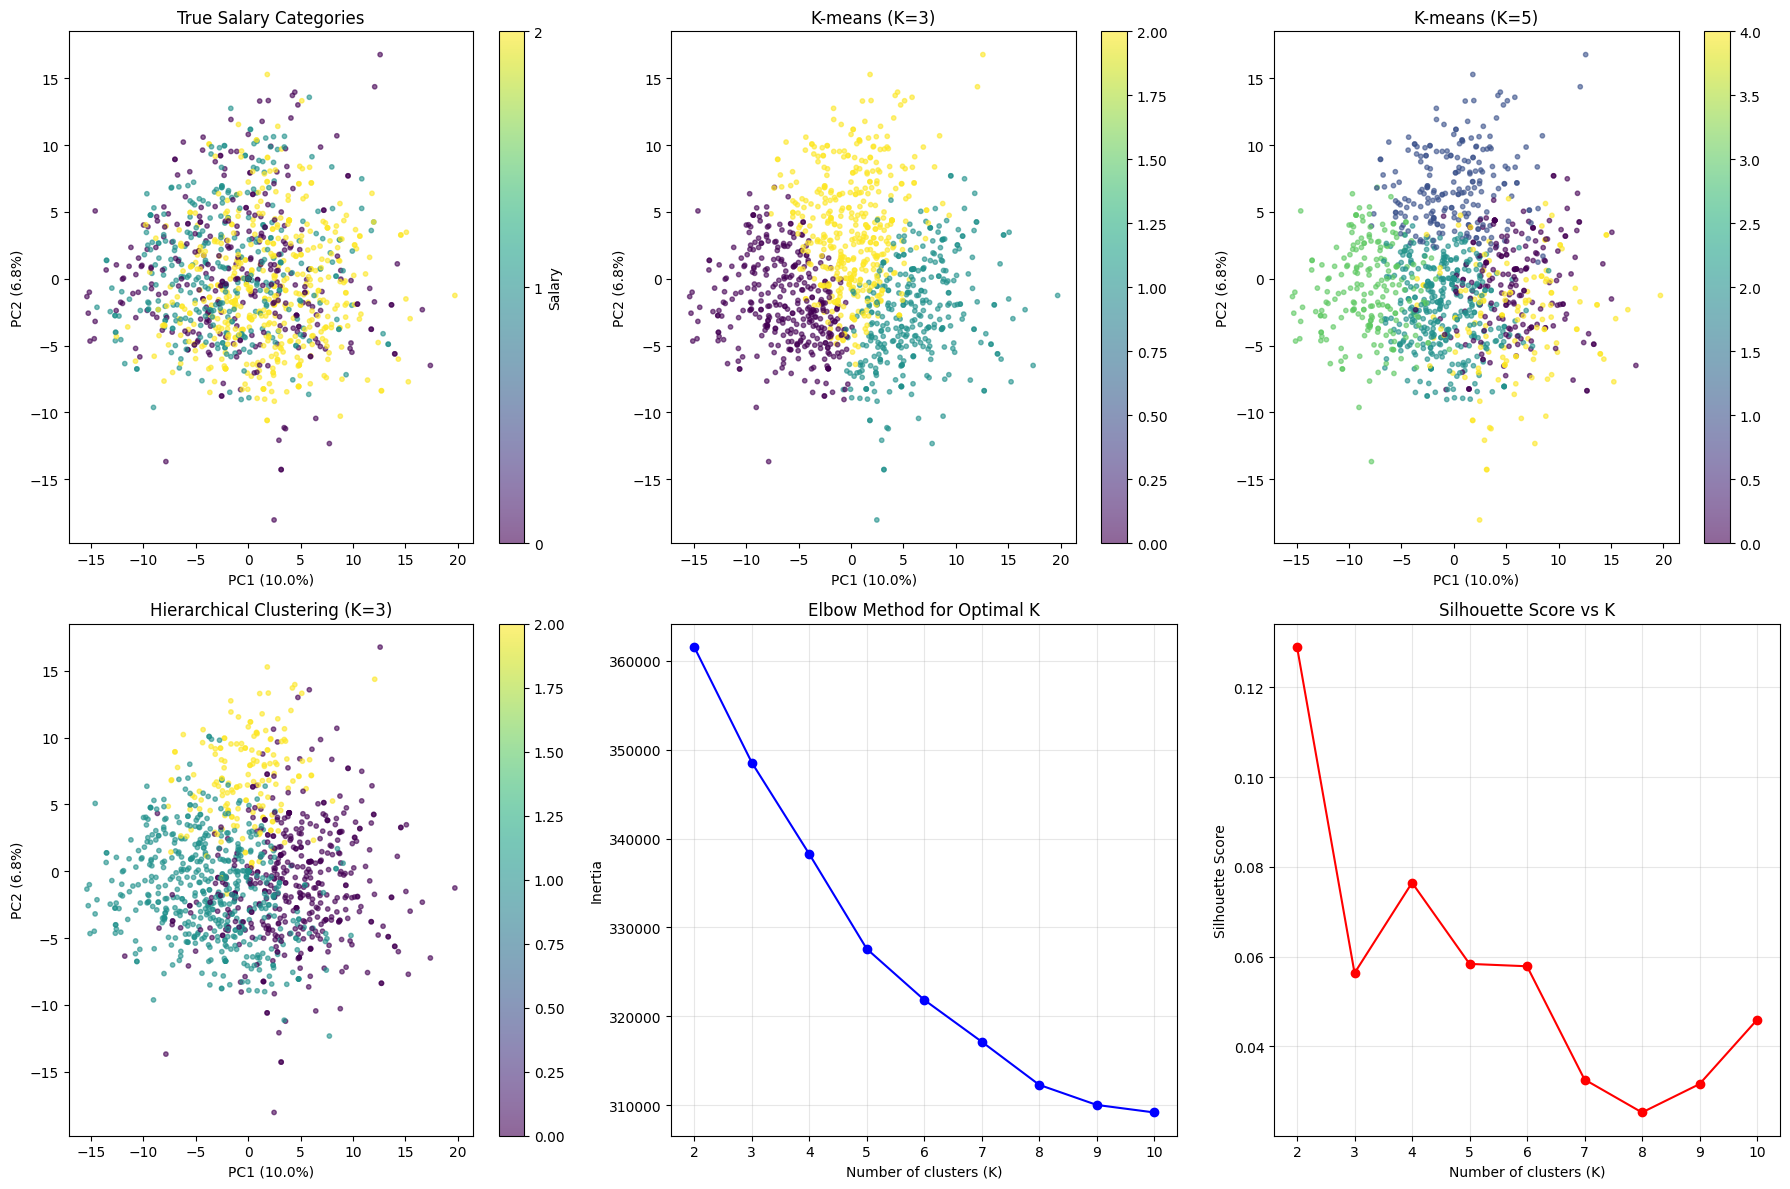

In [14]:
# 6. Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: True salary categories
ax = axes[0, 0]
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], 
                    c=true_labels, cmap='viridis', alpha=0.6, s=10)
ax.set_title('True Salary Categories')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter, ax=ax, ticks=[0, 1, 2], label='Salary')

# Plot 2: K-means (K=3)
ax = axes[0, 1]
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], 
                    c=kmeans_3_labels, cmap='viridis', alpha=0.6, s=10)
ax.set_title('K-means (K=3)')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter, ax=ax)

# Plot 3: K-means (K=5)
ax = axes[0, 2]
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], 
                    c=kmeans_5_labels, cmap='viridis', alpha=0.6, s=10)
ax.set_title('K-means (K=5)')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter, ax=ax)

# Plot 4: Hierarchical
ax = axes[1, 0]
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], 
                    c=hierarchical_labels, cmap='viridis', alpha=0.6, s=10)
ax.set_title('Hierarchical Clustering (K=3)')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.colorbar(scatter, ax=ax)

# Plot 5: Elbow curve
ax = axes[1, 1]
ax.plot(K_range, inertias, 'bo-')
ax.set_xlabel('Number of clusters (K)')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method for Optimal K')
ax.grid(True, alpha=0.3)

# Plot 6: Silhouette scores
ax = axes[1, 2]
ax.plot(K_range, silhouette_scores, 'ro-')
ax.set_xlabel('Number of clusters (K)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score vs K')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('job_desc_clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


Performing t-SNE visualization (this may take a minute)...


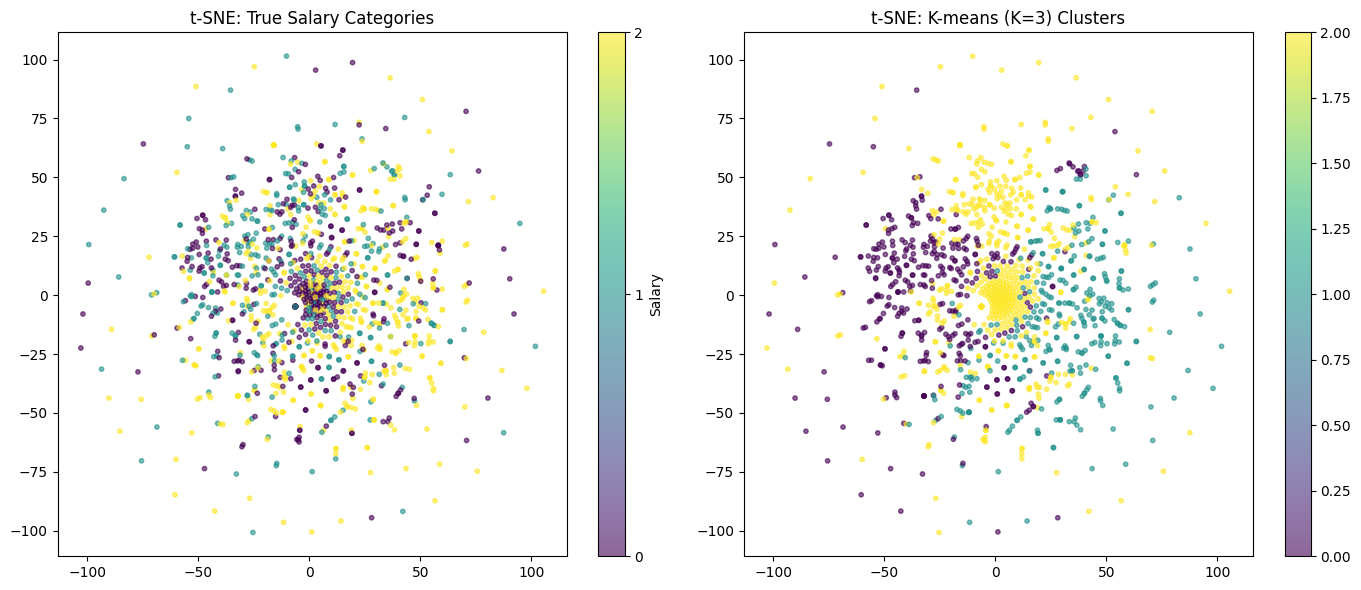

In [15]:
# 7. T-SNE visualization (optional, takes time)
print("\nPerforming t-SNE visualization (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(df_desc_scaled[:5000])  # Use subset for speed

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# True labels
ax = axes[0]
scatter = ax.scatter(tsne_features[:, 0], tsne_features[:, 1], 
                    c=true_labels[:5000], cmap='viridis', alpha=0.6, s=10)
ax.set_title('t-SNE: True Salary Categories')
plt.colorbar(scatter, ax=ax, ticks=[0, 1, 2], label='Salary')

# K-means clusters
ax = axes[1]
scatter = ax.scatter(tsne_features[:, 0], tsne_features[:, 1], 
                    c=kmeans_3_labels[:5000], cmap='viridis', alpha=0.6, s=10)
ax.set_title('t-SNE: K-means (K=3) Clusters')
plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.savefig('job_desc_tsne_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# 8. Cluster characteristics analysis
print("\nAnalyzing cluster characteristics...")

# For each K-means cluster, find average salary distribution
for k in range(3):
    cluster_mask = kmeans_3_labels == k
    cluster_salaries = true_labels[cluster_mask]
    
    print(f"\nCluster {k} (n={sum(cluster_mask)}):")
    for salary, salary_name in [(0, 'Low'), (1, 'Medium'), (2, 'High')]:
        pct = 100 * sum(cluster_salaries == salary) / len(cluster_salaries)
        print(f"  {salary_name}: {pct:.1f}%")

# Summary
print("\n" + "="*60)
print("CLUSTERING ANALYSIS SUMMARY:")
print("="*60)
print(f"1. Job description features show moderate clustering structure")
print(f"2. Optimal K appears to be around 3-5 based on elbow method")
print(f"3. Best silhouette score: {max(silhouette_scores):.3f} at K={K_range[np.argmax(silhouette_scores)]}")
print(f"4. Only {sum(pca.explained_variance_ratio_):.1%} variance explained by 2 PCs")
print(f"5. Need {n_components_90} components for 90% variance")
print(f"6. Clusters show some correlation with salary categories but not perfect separation")
print("\nConclusion: Job descriptions contain useful structure but may need")
print("combination with other features for better salary prediction.")


Analyzing cluster characteristics...

Cluster 0 (n=351):
  Low: 30.2%
  Medium: 41.3%
  High: 28.5%

Cluster 1 (n=339):
  Low: 20.9%
  Medium: 17.1%
  High: 61.9%

Cluster 2 (n=590):
  Low: 41.0%
  Medium: 26.6%
  High: 32.4%

CLUSTERING ANALYSIS SUMMARY:
1. Job description features show moderate clustering structure
2. Optimal K appears to be around 3-5 based on elbow method
3. Best silhouette score: 0.129 at K=2
4. Only 16.8% variance explained by 2 PCs
5. Need 105 components for 90% variance
6. Clusters show some correlation with salary categories but not perfect separation

Conclusion: Job descriptions contain useful structure but may need
combination with other features for better salary prediction.


In [22]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

class JobDescriptionClusterTransformer(BaseEstimator, TransformerMixin):
    """
    Transform job description columns into cluster-based features.
    Designed to work within sklearn pipelines.
    """
    
    def __init__(self, n_clusters=5, use_probabilities=True, random_state=42):
        self.n_clusters = n_clusters
        self.use_probabilities = use_probabilities
        self.random_state = random_state
        
        # Initialize preprocessing and clustering
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = StandardScaler()
        self.kmeans = KMeans(
            n_clusters=n_clusters,
            random_state=random_state,
            n_init=10
        )
        
    def fit(self, X, y=None):
        """Fit the clustering model on job description features."""
        # X should already be the job description columns only
        X_array = X.values if hasattr(X, 'values') else X
        
        # Replace zeros with NaN
        X_array = np.where(X_array == 0, np.nan, X_array)
        
        # Preprocess
        X_imputed = self.imputer.fit_transform(X_array)
        X_scaled = self.scaler.fit_transform(X_imputed)
        
        # Fit clustering
        self.kmeans.fit(X_scaled)
        
        return self
    
    def transform(self, X):
        """Transform job descriptions into cluster features."""
        X_array = X.values if hasattr(X, 'values') else X
        
        # Replace zeros with NaN
        X_array = np.where(X_array == 0, np.nan, X_array)
        
        # Preprocess
        X_imputed = self.imputer.transform(X_array)
        X_scaled = self.scaler.transform(X_imputed)
        
        if self.use_probabilities:
            # Calculate distances to each cluster center
            distances = self.kmeans.transform(X_scaled)
            
            # Convert distances to probabilities
            neg_distances = -distances
            exp_distances = np.exp(neg_distances - np.max(neg_distances, axis=1, keepdims=True))
            probabilities = exp_distances / np.sum(exp_distances, axis=1, keepdims=True)
            
            # Create output array
            n_features = self.n_clusters + 1  # probabilities + min_distance
            output = np.zeros((X_array.shape[0], n_features))
            output[:, :self.n_clusters] = probabilities
            output[:, self.n_clusters] = np.min(distances, axis=1)
            
            return output
        else:
            # Hard cluster assignment
            cluster_labels = self.kmeans.predict(X_scaled)
            # One-hot encode
            output = np.zeros((X_array.shape[0], self.n_clusters))
            output[np.arange(len(cluster_labels)), cluster_labels] = 1
            return output
    
    def get_feature_names_out(self, input_features=None):
        """Return feature names for output features."""
        if self.use_probabilities:
            names = [f'job_cluster_prob_{i}' for i in range(self.n_clusters)]
            names.append('job_cluster_min_dist')
        else:
            names = [f'job_cluster_{i}' for i in range(self.n_clusters)]
        return np.array(names)


# Modified DataHandler to include clustering
def create_pipeline_with_clustering(n_clusters=5):
    """
    Modified version of DataHandler's create_pipeline that includes clustering.
    """
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    
    # Import your custom transformers (adjust import paths as needed)
    from Classes.DataHandler import (
        FeatureExtractor, 
        CustomJobStateFeature1Transformer,
        DateFeaturesTransformer
    )
    
    # Instantiate FeatureExtractor to get column lists
    fe = FeatureExtractor()
    bool_cols = fe.bool_columns
    quant_cols = fe.quantitative_columns
    job_desc_cols = fe.job_desc_cols

    # 1) preprocessor: feature creation with clustering
    preprocessor_ct = ColumnTransformer(
        transformers=[
            # Original transformers
            ("js_f1", Pipeline([("custom", CustomJobStateFeature1Transformer())]),
             ["job_state", "feature_1"]),
            ("title", OneHotEncoder(handle_unknown="ignore", sparse_output=False),
             ["job_title"]),
            ("date", DateFeaturesTransformer(), ["job_posted_date"]),
            ("bools", "passthrough", bool_cols),
            ("quants", "passthrough", quant_cols),
            
            # NEW: Job description clustering instead of passthrough
            ("jobdesc_cluster", JobDescriptionClusterTransformer(
                n_clusters=n_clusters, 
                use_probabilities=True
            ), job_desc_cols),
        ],
        remainder="drop"
    ).set_output(transform="pandas")

    # 2) imputer: mean on all columns
    imputer = SimpleImputer(strategy="mean").set_output(transform="pandas")

    # 3) scaler: scale only non-binary numeric columns
    # Update scale_cols to include cluster features
    scale_cols = (
        ["js_f1__job_state", "date__months_since_first", "date__month_of_year"] +
        [f"quants__{col}" for col in quant_cols] +
        [f"jobdesc_cluster__job_cluster_prob_{i}" for i in range(n_clusters)] +
        ["jobdesc_cluster__job_cluster_min_dist"]
    )
    
    scaler_ct = ColumnTransformer(
        transformers=[
            ("scale", StandardScaler(), scale_cols),
        ],
        remainder="passthrough"
    ).set_output(transform="pandas")

    pipeline = Pipeline([
        ("feature_extractor", FeatureExtractor()),
        ("preprocessor", preprocessor_ct),
        ("imputer", imputer),
        ("scaler", scaler_ct),
    ])
    
    return pipeline


# Standalone function to add clustering to existing data
def add_cluster_features_to_datahandler(data_handler, n_clusters=5):
    """
    Modify an existing DataHandler instance to use clustering.
    """
    # Replace the pipeline with clustering version
    data_handler.pipeline = create_pipeline_with_clustering(n_clusters)
    
    print(f"Updated DataHandler pipeline to use {n_clusters} job description clusters")
    
    # Test on sample data
    X_train_raw, y_train, _ = data_handler.get_train_data_raw()
    X_sample = X_train_raw.head(100)
    
    try:
        X_transformed = data_handler.pipeline.fit_transform(X_sample)
        print(f"Pipeline output shape: {X_transformed.shape}")
        print(f"Pipeline output columns: {list(X_transformed.columns[:10])}...")
    except Exception as e:
        print(f"Pipeline test failed: {e}")
    
    return data_handler


# Example usage
if __name__ == "__main__":
    from Classes.DataHandler import DataHandler
    
    # Initialize DataHandler
    print("Initializing DataHandler with clustering...")
    data_handler = DataHandler()
    
    # Replace pipeline with clustering version
    data_handler = add_cluster_features_to_datahandler(data_handler, n_clusters=5)
    
    # Now use the modified data_handler with your neural network training
    print("\nReady to use with neural network training!")
    
    # Test the transformation
    X_train_raw, y_train, _ = data_handler.get_train_data_raw()
    X_transformed = data_handler.pipeline.fit_transform(X_train_raw)
    
    print(f"\nFinal transformed shape: {X_transformed.shape}")
    print(f"Original shape: {X_train_raw.shape}")
    print(f"Feature reduction: {X_train_raw.shape[1]} -> {X_transformed.shape[1]} columns")

Initializing DataHandler with clustering...
Updated DataHandler pipeline to use 5 job description clusters
Pipeline output shape: (100, 36)
Pipeline output columns: ['scale__js_f1__job_state', 'scale__date__months_since_first', 'scale__date__month_of_year', 'scale__quants__feature_2', 'scale__quants__feature_10', 'scale__jobdesc_cluster__job_cluster_prob_0', 'scale__jobdesc_cluster__job_cluster_prob_1', 'scale__jobdesc_cluster__job_cluster_prob_2', 'scale__jobdesc_cluster__job_cluster_prob_3', 'scale__jobdesc_cluster__job_cluster_prob_4']...

Ready to use with neural network training!

Final transformed shape: (1280, 49)
Original shape: (1280, 316)
Feature reduction: 316 -> 49 columns


In [24]:
from Classes.DataHandler import DataHandler

# Initialize DataHandler
data_handler = DataHandler()

# Replace pipeline with clustering version
data_handler = add_cluster_features_to_datahandler(data_handler, n_clusters=5)

# Now use it with your neural network training
from NNTest import train_ordinal_NN_with_hyperopt
best_pipeline, best_params, cv_score = train_ordinal_NN_with_hyperopt(
    data_handler, 
    n_iter=5,
    cv_folds=5
)

Updated DataHandler pipeline to use 5 job description clusters
Pipeline output shape: (100, 36)
Pipeline output columns: ['scale__js_f1__job_state', 'scale__date__months_since_first', 'scale__date__month_of_year', 'scale__quants__feature_2', 'scale__quants__feature_10', 'scale__jobdesc_cluster__job_cluster_prob_0', 'scale__jobdesc_cluster__job_cluster_prob_1', 'scale__jobdesc_cluster__job_cluster_prob_2', 'scale__jobdesc_cluster__job_cluster_prob_3', 'scale__jobdesc_cluster__job_cluster_prob_4']...
Input size after preprocessing: 49
Feature names: ['scale__js_f1__job_state', 'scale__date__months_since_first', 'scale__date__month_of_year', 'scale__quants__feature_2', 'scale__quants__feature_10', 'scale__jobdesc_cluster__job_cluster_prob_0', 'scale__jobdesc_cluster__job_cluster_prob_1', 'scale__jobdesc_cluster__job_cluster_prob_2', 'scale__jobdesc_cluster__job_cluster_prob_3', 'scale__jobdesc_cluster__job_cluster_prob_4']...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

In [96]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans, Birch, SpectralClustering, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_algorithms(X, algorithms):
    """
    X: preprocessed array or DataFrame values
    algorithms: dict of name -> fitted estimator or factory function
    """
    results = {}
    for name, alg_factory in algorithms.items():
        try:
            # Instantiate or get estimator
            alg = alg_factory()
            labels = None
            # Fit & predict/score
            if hasattr(alg, 'fit_predict'):
                labels = alg.fit_predict(X)
            else:
                alg.fit(X)
                if hasattr(alg, 'predict'):
                    labels = alg.predict(X)
                elif hasattr(alg, 'labels_'):
                    labels = alg.labels_
                else:
                    print(f"{name}: cannot get labels")
                    continue
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters <= 1:
                print(f"{name}: only {n_clusters} cluster(s) found")
                continue
            sil = silhouette_score(X, labels)
            ch = calinski_harabasz_score(X, labels)
            db = davies_bouldin_score(X, labels)
            results[name] = {
                'n_clusters': n_clusters, 
                'silhouette': sil, 
                'calinski_harabasz': ch, 
                'davies_bouldin': db
            }
            print(f"{name}: clusters={n_clusters}, silhouette={sil:.3f}, CH={ch:.1f}, DB={db:.3f}")
        except Exception as e:
            print(f"{name}: failed with error {e}")
    return results

# Example usage after preprocessing df_desc_scaled:
algorithms = {
    # "KMeans_3": lambda: KMeans(n_clusters=3, random_state=42, n_init=10),
    # "KMeans_5": lambda: KMeans(n_clusters=5, random_state=42, n_init=10),
    # "MiniBatchKMeans_3": lambda: MiniBatchKMeans(n_clusters=3, random_state=42),
    # "Birch_default": lambda: Birch(n_clusters=3),
    # "GMM_3": lambda: GaussianMixture(n_components=3, random_state=42),
    # "Agglomerative_ward_3": lambda: AgglomerativeClustering(n_clusters=3, linkage='ward'),
    # "Spectral_3": lambda: SpectralClustering(n_clusters=3, random_state=42, affinity='nearest_neighbors'),
    # "OPTICS": lambda: OPTICS(min_samples=10),
    "DBSCAN": lambda: DBSCAN(eps=20, min_samples=3),
    # Add more as desired
}

results = evaluate_algorithms(df_desc_scaled, algorithms)


DBSCAN: clusters=4, silhouette=0.156, CH=12.5, DB=2.692


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

# 1. K-distance plot for initial eps estimation
def plot_k_distance(X, min_samples=10):
    """
    Plot the sorted distance to the k-th nearest neighbor for each point,
    to help choose a candidate eps for DBSCAN.
    """
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    # distances[:, -1] is distance to the min_samples-th neighbor
    k_distances = np.sort(distances[:, -1])
    plt.figure(figsize=(8, 4))
    plt.plot(k_distances)
    plt.xlabel(f"Points sorted by distance to their {min_samples}th NN")
    plt.ylabel(f"{min_samples}th nearest neighbor distance")
    plt.title(f"k-distance Plot (min_samples={min_samples})")
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage:
# plot_k_distance(X_scaled, min_samples=10)
# Inspect the “elbow” in this curve to pick a candidate eps.

# 2. Grid search over eps and min_samples
def dbscan_param_search(X, eps_values, min_samples_values, silhouette_min_samples=5):
    """
    Search DBSCAN over eps_values and min_samples_values.
    Returns a DataFrame with columns: eps, min_samples, n_clusters, noise_pct, silhouette.
    Silhouette is computed on non-noise points if at least 2 clusters present.
    """
    records = []
    n_samples = X.shape[0]
    for min_samples in min_samples_values:
        # Optionally, you can re-plot k-distance for each min_samples if desired
        for eps in eps_values:
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(X)
            unique = set(labels)
            n_clusters = len(unique) - (1 if -1 in unique else 0)
            pct_noise = 100.0 * np.sum(labels == -1) / n_samples
            sil = np.nan
            if n_clusters > 1:
                mask = labels != -1
                # Need at least 2 clusters among non-noise and enough points
                if mask.sum() >= silhouette_min_samples and len(set(labels[mask])) > 1:
                    try:
                        sil = silhouette_score(X[mask], labels[mask])
                    except:
                        sil = np.nan
            records.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_pct': pct_noise,
                'silhouette': sil
            })
    df_results = pd.DataFrame(records)
    return df_results

# Example usage:
# 1) Decide eps_values range based on k-distance plot. E.g., if distances range ~[0.5, 5.0], choose:
#    eps_values = np.linspace(0.5, 5.0, 10)
# 2) Choose min_samples_values, e.g. [5, 10, 15, 20]
#    df_db = dbscan_param_search(X_scaled, eps_values, min_samples_values=[5, 10, 15, 20])
# 3) Examine results:
#    # Filter rows with >1 cluster
#    df_good = df_db[df_db['n_clusters'] > 1].copy()
#    # Sort by silhouette descending
#    df_good_sorted = df_good.sort_values(by='silhouette', ascending=False)
#    print(df_good_sorted.head(10))
#    # Also check noise_pct to avoid too much noise
#    print(df_good_sorted[['eps','min_samples','n_clusters','noise_pct','silhouette']].head(10))

# 4) If no combinations yield >1 cluster, consider:
#    - Expanding eps range (larger or smaller)
#    - Trying PCA-reduced data: repeat on X_pca50
#    - Adjusting min_samples range
#    - Scaling features differently or using alternative embeddings

# Full example sequence:
# ------------------------------------------------
# # 1. Plot k-distance for a few min_samples
# for ms in [5, 10, 15]:
#     plot_k_distance(X_scaled, min_samples=ms)
#
# # 2. After eyeballing candidate eps range from plot(s), define eps_values:
# eps_values = np.linspace(0.5, 10.0, 20)  # adjust start/end and number of points
# min_samples_values = [5, 10, 15, 20]
# df_db = dbscan_param_search(X_scaled, eps_values, min_samples_values)
#
# # 3. Inspect results
# df_good = df_db[df_db['n_clusters'] > 1].copy()
# if not df_good.empty:
#     df_good_sorted = df_good.sort_values(by='silhouette', ascending=False)
#     print(df_good_sorted.head(10))
# else:
#     print("No DBSCAN setting produced more than one cluster; consider changing eps/min_samples or using PCA-reduced data.")
#
# # 4. If needed, repeat on PCA:
# X_pca50 = PCA(n_components=50, random_state=42).fit_transform(X_scaled)
# df_db_pca = dbscan_param_search(X_pca50, eps_values, min_samples_values)
# df_good_pca = df_db_pca[df_db_pca['n_clusters'] > 1].sort_values(by='silhouette', ascending=False)
# print(df_good_pca.head(10))
# ------------------------------------------------

# After identifying one or more promising (eps, min_samples) pairs:
# - Fit DBSCAN with those params in your transformer:
#     dbscan_est = DBSCAN(eps=best_eps, min_samples=best_min_samples)
#     jd_dbscan = JobDescriptionClusterTransformer(
#         clustering_estimator=dbscan_est,
#         use_probabilities=False
#     )
# - Plug into your ColumnTransformer pipeline and evaluate downstream model performance.

# Note:
# - Silhouette on non-noise gives a sense of cluster tightness. But a lower silhouette doesn't always mean no predictive value.
# - Monitor noise_pct: too high noise means most points unlabeled (still may include noise indicator feature).
# - If DBSCAN never yields useful clusters on full data, try on PCA/UMAP embeddings or alternative feature representations.
